## Markov Chain Monte Carlo Simulation of Precipitation Data
### David Islip

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import scipy.stats as stats
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.tsa.ar_model as ar_model
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
from collections import Counter
import pickle
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BF9D208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D743400>]], dtype=object)

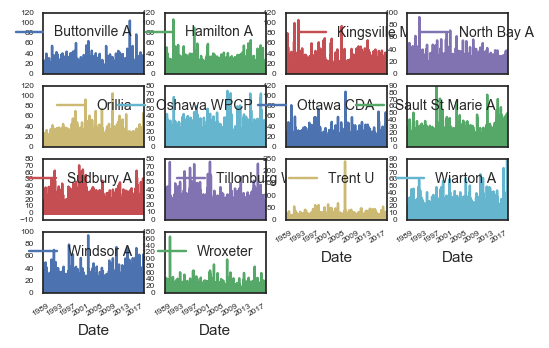

In [3]:
P = pd.read_csv("Cleaned Precipitation.csv")

P.rename(columns={P.columns[0]: 'Date'}, inplace=True)
P.index = pd.to_datetime(P["Date"])
P.drop(P.index[P.index.dayofyear == 366],axis=0, inplace = True)
P.drop("Date", axis = 1, inplace = True)
P = P['1987-01-01':'2017-01-01 ']
P.plot(subplots = True, fontsize = 6,layout = (4,4))

In [4]:
y = P['Buttonville A']

In [5]:
state = y > 0.1
def estimateMarkov(state):
    p = np.zeros((2,2))
    for (a,b), c in Counter(zip(state, state[1:])).items():
        p[a-1,b-1] = c
    
    return p.flatten()

In [6]:
T = {}
for yr in range(state.index[0].year,state.index[-1].year):
    temp_yr = state[state.index.year == yr]
    for mn in range(1,12+1):
        T[(yr,mn)] = estimateMarkov(temp_yr[temp_yr.index.month == mn])
        

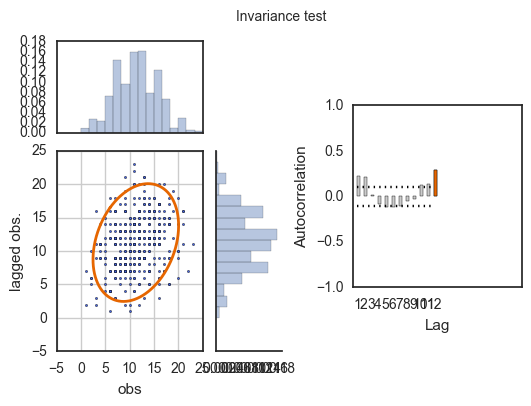

In [7]:
Trans_Probs = pd.DataFrame(T).transpose()
Trans_Probs.index.names = ['1','2']
z = np.array(Trans_Probs[3])
z = np.expand_dims(z, axis=0)

lag_ = 24 # number of lags (for auto correlation test)
acf = autocorrelation(z, lag_)

lag = 12  # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
InvarianceTestEllipsoid(z, acf[0,1:], lag, fit, ell_scale);

### Factor modelling the transition probabilities 

In [10]:
Z = np.array(Trans_Probs)
#generating the factor space for the mean
a = np.ones(len(Z))
N = 5 #number of sine and cosine functions to include
n = np.linspace(1,N,N)
t = np.linspace(1,len(Z),len(Z))
Sines = np.sin(2*np.pi*(np.outer(t,n))/12)
Cosines = np.cos(2*np.pi*(np.outer(t,n))/12)
X = np.expand_dims(a, axis=1)
X = np.concatenate((X,Sines,Cosines),axis=1)

(360, 11)

Results for model: 0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     65.80
Date:                Thu, 02 Nov 2017   Prob (F-statistic):           8.06e-15
Time:                        20:18:39   Log-Likelihood:                -910.95
No. Observations:                 360   AIC:                             1826.
Df Residuals:                     358   BIC:                             1834.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5417      0.16

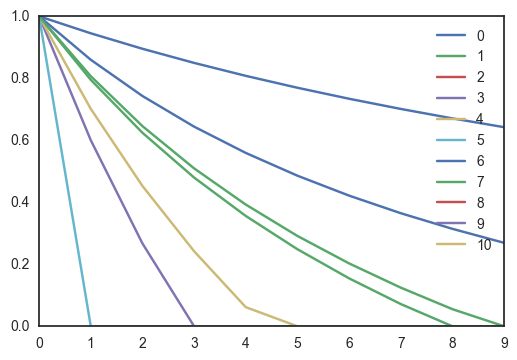

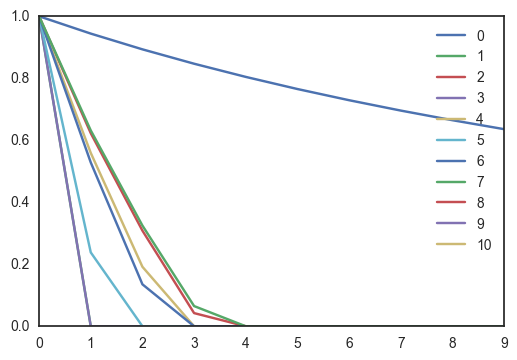

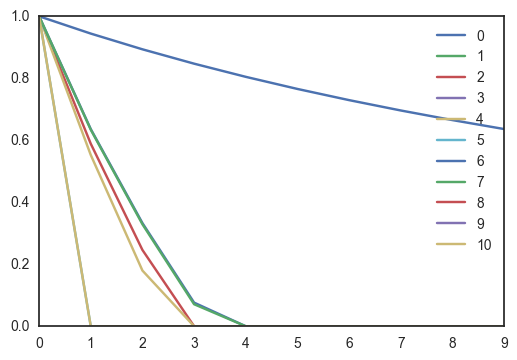

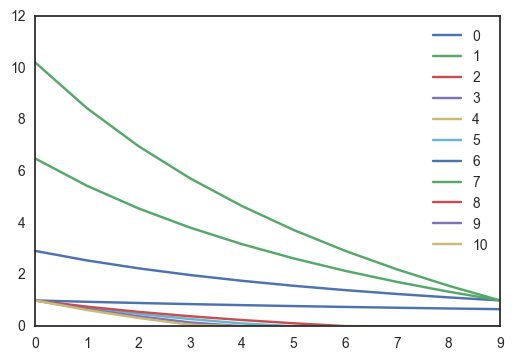

In [11]:
model_results = []
factors = []
for k in range(Z.shape[1]):
    z = Z[:,k]
    L = []
    model = sm.OLS(z, X)
    for i in range(10):
        results = model.fit_regularized(method = 'elastic_net',alpha=i/10, L1_wt=0.5)
        L.append(results.params)
    L = pd.DataFrame(L)
    L = L/L.max(axis=0)
    cols = L.columns[L.ix[len(L)-1] > 0.001]
    factors.append(cols)
    Xs = X[:,cols]
    model = sm.OLS(z,Xs)
    results = model.fit()
    print("Results for model: "+str(k))
    L.plot()
    print(results.summary())
    model_results.append(results)

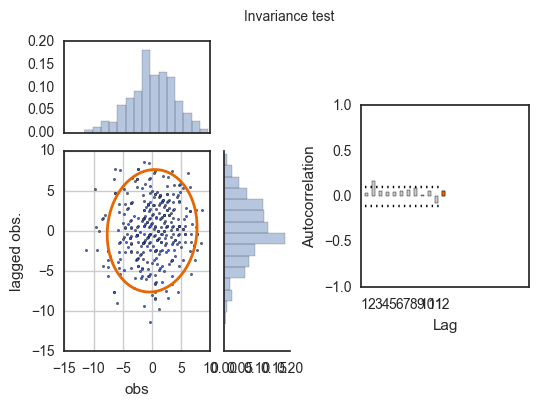

In [12]:
z = np.expand_dims(model_results[3].predict()-Z[:,3], axis=0)
lag_ = 24 # number of lags (for auto correlation test)
acf = autocorrelation(z, lag_)

lag = 12  # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
InvarianceTestEllipsoid(z, acf[0,1:], lag, fit, ell_scale);

### Factor Modelling of the transition probabilities was not great
### Here are the Naive monthly transition matrices 

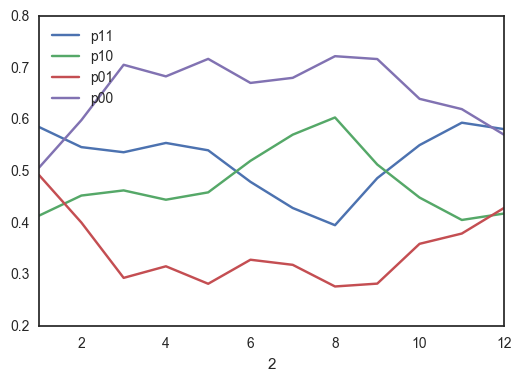

In [13]:
T = Trans_Probs.groupby(level='2').sum()
T['p11'] = T[0]/(T[0]+T[1])
T['p10'] = T[1]/(T[0]+T[1])
T['p01'] = T[2]/(T[2]+T[3])
T['p00'] = T[3]/(T[2]+T[3])
T.drop([0,1,2,3],axis = 1,inplace = True)
T.plot()

### Plot some monte carlo simulations (dry/wet)

In [98]:
#tau is the risk horizon
tau_ = 365*2
tau = dt.timedelta(days = tau_)

start = pd.Timestamp('2017-01-01')
end = start+tau

t = np.linspace(start.value, end.value, tau_)
t = pd.to_datetime(t)

M = 1000

invariants  = np.random.uniform(0, 1, (tau_,M))
X_precip = np.zeros((tau_,M))
zero = np.zeros(M)
one = np.ones(M)
for i in range(tau_-1):
    month = t[i].month
    #state zero
    X_precip[i+1,X_precip[i,] < 1] = invariants[i+1,X_precip[i,] < 1] > T.ix[month]['p00']
    #state 1
    X_precip[i+1,X_precip[i,] == 1] = invariants[i+1,X_precip[i,] == 1] > T.ix[month]['p10']
#plt.plot(pd.rolling_mean(X_precip,30))
#X_precip.mean()

In [95]:
estimateMarkov(X_precip.flatten())
wet.shape

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1, 4586)

### IID test for the non zero precipitation values

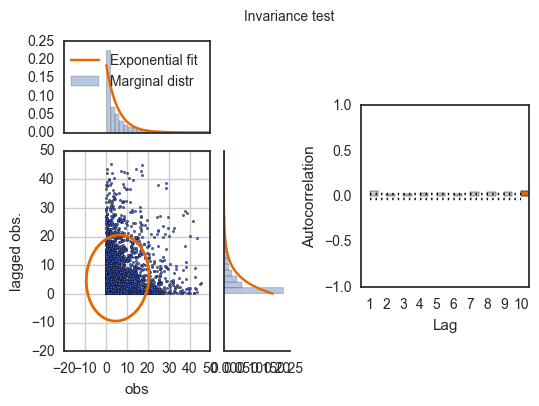

In [97]:
wet = np.expand_dims(y[y>0.1],axis = 0)
lag_ = 10 # number of lags (for auto correlation test)
acf = autocorrelation(wet, lag_)

lag = 10 # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 2  # normal fitting
InvarianceTestEllipsoid(wet, acf[0,1:], lag, fit, ell_scale);

In [99]:
X_precip.shape
P_path = np.multiply(np.random.choice(wet[0,:],[tau_,M]), X_precip)
#plt.plot(P_path)

### Pickle the simulations

In [100]:
P_out = pd.DataFrame(P_path)
P_out.index = np.arange(P.index[-1],P.index[-1] + dt.timedelta(tau_),dt.timedelta(days=1)).astype(dt.datetime)
P_out.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Pout.pkl")